In [1]:
# By Lyndon White (AKA oxinabox, AKA Frames)

In [3]:
codetext = """const cache_location = joinpath(Pkg.Dir.path(),"../jltags_cache/"); kinds = Dict("module"=>"module", "variable"=>"variable", "function"=>"function", "datatype"=>"datatype", "union"=>"union", "type" =>"type"); immutable Tag; name::AbstractString; file::AbstractString; address::AbstractString; fields::Dict{AbstractString,AbstractString}; const mtime_line_prefix = "!_TAG_SOURCE_MTIME"; function write_header(fp::IO, file_mtimes=[]); println(fp,"!_TAG_FILE_FORMAT  2  /exted format; --format=1 will not app\" to lines/"); println(fp,"!_TAG_FILE_SORTED  0  /0=unsorted, 1=sorted, 2=foldcase/"); println(fp,"!_TAG_PROGRAM_NAME jltags //"); for (filename, mtime) in file_mtimes; println(fp,mtime_line_prefix,"\t",filename,"\t",string(mtime)); function write_tag(fp::IO, tag::Tag); tag.fields["language"]="julia"; print(fp, "(tag.name)\t(tag.file)\t(tag.address);\""); for (field,value) in tag.fields; value = escape_string(value); print(fp,"\tfield:value"); println(fp); function module_to_filename(mm::Module); name = mm==Base ? "sysimg" : mm==Core ? "coreimg": string(mm); path = Base.find_source_file(name*".jl"); path!=nothing ? path : "<module name: unknown path>" function docs(func::Function, method::Method); try signiture_types = method.sig.types[2:]; doc = Base.Docs.doc(func,signiture_types...); return doc.meta[:results][1].text[1] catch ee; return "No docs found for " * string(method); function tags(name_sym::Symbol, mm::Module, value::Function); name=string(name_sym); Task() do; for func in Base.MethodList(methods(value)); if mm!=func.module continue file, linenum = functionloc(func); address = string(linenum); args = map(string, func.sig.parameters[2:]) ; fields = Dict{AbstractString,AbstractString}(; "module" => mm|>string, "kind" => kinds["function"], "arity" => string(length(args)), "args" => join(args,","), "string" => string(func), "doc" => docs(value, func), ); produce(Tag(name,file,address,fields)) ; function tags(name_sym::Symbol, mm::Module, value::Union); name=string(name_sym); Task() do; filename=module_to_filename(mm) fields=Dict("kind" => kinds["union"], "module"=> string(mm), "types" => join(",",map(string,value.types)), "string" => string(value); ); produce(Tag(name,filename,"/name\\s*=/",fields)) ; function tags(name_sym::Symbol,mm::Module, tt::DataType, record_truename=false); name=string(name_sym); Task() do; filename = module_to_filename(mm) fields=Dict("kind" => kinds["datatype"], "module"=> string(mm), "other_type_parameters"=>join(",",map(string, setdiff(tt.parameters,tt.types))), "abstract"=> tt.abstract |> string, "mutable"=> tt.mutable |> string, "size"=> tt.size |> string, "supertype"=>supertype(tt) |> string, "bitstype"=>isbits(tt) |> string, "string" => string(tt); ); if record_truename; fields["true_name"]=tt.name.name |> string; if tt.name.names |> length >= nfields(tt) if name_sym != :Module type_fields = ["fname::"*string(fieldtype(tt,fname)) for fname in fieldnames(tt)]; fields["fields"] = join(type_fields,","); produce(Tag(name,filename, "/^[typealias|type|abstract|immutable]\\s+name\\s*=/", fields)); function tags(name_sym::Symbol, mm::Module, value::Type); Task() do; for tag in  tags(name_sym,mm,value.body); tag.fields["kind"] = kinds["type"]; tag.fields["inner_string"]=tag.fields["string"]; tag.fields["string"] = string(value); produce(tag); function tags(name_sym::Symbol,mm::Module, submodule::Module); name=string(name_sym); Task() do; filename = module_to_filename(submodule); fields=Dict("kind" => kinds["module"], "module"=> module_parent(submodule) |> string, "string"=> string(submodule)); produce(Tag(name,filename, "/^module name/",fields)); function tags(name_sym::Symbol,mm::Module, variable::Any); name=string(name_sym); Task() do; filename=module_to_filename(mm) fields=Dict("kind" => kinds["variable"], "module"=> string(mm), "type" => string(typeof(variable)), "constant" => string(isconst(mm,name_sym)), "string" => string(variable)); produce(Tag(name,filename, "/name\\s*=/",fields)) ; function tags_from_module(mm::Module); try; println(STDERR, "++ Generating Tags from mm ++"); Task() do for name_sym in names(mm); value = eval(mm,name_sym); map(produce, tags(name_sym, mm, value)); |> collect; catch ee; warn(string(Module)*" tagging failed. As "* string(ee)); []; function name2module(name); eval(parse("import "*name)); eval(parse(name)); function create_module_tagsfile(cache_name, module_name); mkpath(cache_location); mod = name2module(module_name); if mod==nothing; warn("(module_name) Not Found"); return nothing; open(cache_name,"w") do fp; tags = tags_from_module(mod) |> collect; file_mtimes = Dict(tag.file=>stat(tag.file).mtime|>Dates.unix2datetime for tag in tags); write_header(fp, file_mtimes); for tag in tags; write_tag(fp,tag); function is_cache_current(cache_name); for line in eachline(cache_name); if line[1:length(mtime_line_prefix)] == mtime_line_prefix; prefix, filename, mtime_str = split(line,"\t"); cached_mtime = DateTime(mtime_str); cur_mtime = stat(filename).mtime |> Dates.unix2datetime; if cached_mtime!=cur_mtime return false; return true; function get_module_tag_file(module_name); println(STDERR, "Sourcing module_name"); cache_name = joinpath(cache_location,module_name*".tags"); if !isfile(cache_name) || !is_cache_current(cache_name); create_module_tagsfile(cache_name, module_name); cache_name; function parseall(str); Task() do pos = start(str); while !done(str, pos); ex, pos = parse(str, pos); produce(ex); function get_modules_names(filename); code = readstring(filename); function inner(::Any); function inner(ee::Expr); if ee.head == :using || ee.head==:importall; module_name = join(map(string,ee.args),"."); produce(module_name); else for arg in ee.args; inner(arg); Task() do; produce("Core"); produce("Base"); for ee in code |> parseall; for mod in @task inner(ee); produce(mod); function make_standalone_tagfile(filename); println(STDERR,"Standalone Tagging filename"); mod_names = get_modules_names(filename); open(joinpath(dirname(filename), "."*basename(filename)*".tags"),"w") do fp; for mod_name in mod_names; tag_file = get_module_tag_file(mod_name); println(fp, open(readstring, tag_file,"r")) function print_refered_tagfile_paths(filename); mod_names = get_modules_names(filename); for mod_name in mod_names; tag_file = get_module_tag_file(mod_name); println(tag_file); if length(ARGS)>0; mode = lowercase(ARGS[1]); if mode == "standalone"; make_standalone_tagfile(ARGS[2]); elseif mode == "refer"; print_refered_tagfile_paths(ARGS[2]); else println("Invalid mode selected.")const binops_renames =Dict( :(<=) => "\\le", :(>=) => "\\ge", :in  => "\\in") const binops = [Symbol.(split("+ - < > ∈ ≈"))..., keys(binops_renames)...] val_or_expr(x::Expr) = x val_or_expr(x) = Val{x}() function MathSequence(v_vs, binop) dlm = to_math(binop) vs = to_math.(collect(v_vs)) frags = Vector{MathExpressionFragment}() sizehint!(frags, 2*length(vs)-1) for v in vs[1:-1] push!(frags,v) push!(frags,dlm) push!(frags, vs[]) MathSequence(frags) to_math(sym::MathSymbolInner) = MathSymbol(sym) to_math{sym}(::Val{sym})= MathSymbol(sym) function to_math(::Val{:call}, v_binop::Union{(Val{binop} for binop in binops)...}, vs...) MathSequence(vs, v_binop) function to_math(::Val{:call}, ::Val{:^}, v_base, v_expo) MathSuperscript(to_math(v_base), to_math(v_expo)) function to_math(::Val{:call}, ::Val{:/}, v_base, v_expo) MathFrac(to_math(v_base), to_math(v_expo)) function to_math{func}(::Val{:call}, v_func::Val{func}, v_args...) MathFunctionCall(func, MathSequence(v_args, Symbol(", "))) function to_math(ast::Expr) to_math(Val{ast.head}(), val_or_expr.(ast.args)... ) to_math(::Val{:vect},vs...) = to_math_vector(vs) function to_math_vector(col) math_col = MathExpressionFragment[to_math(c) for c in col] MathMatrix(math_col[:,:])  to_math(::Val{:hcat},row...) = to_math_matrix(row) function to_math_matrix(rows...) function math_row(row) row_vec = MathExpressionFragment[to_math(r) for r in row.args] permutedims(row_vec[:,:], (2,1))   MathMatrix(vcat(map(math_row, rows)...)) function to_math(::Val{:vcat},vs...) if typeof(vs[1])<:Expr && vs[1].head == :row to_math_matrix(vs...) else to_math_vector(vs)  "Note: Does not (currently) escape all of latex." function escape_latex(s::AbstractString) replace(s,"_","\_") latex_brace(x::AbstractString) = "{" * x * "}" to_latex(s::MathSymbolInner) = to_latex("s") to_latex(s::AbstractString) = escape_latex(s) to_latex(x::MathSymbol) = to_latex(x.sym) function to_latex(x::MathSuperscript) to_latex(x.base) * "^" * latex_brace(to_latex(x.expo)) function to_latex(x::MathFrac) "\\frac" * latex_brace(to_latex(x.numer)) * latex_brace(to_latex(x.denom)) function to_latex(x::MathFunctionCall) name = x.fname |> string |> escape_latex if length(name) > 1 name = "\\mathrm"*latex_brace(name)  name*to_latex(x.arg) function to_latex(x::MathMatrix)  desc = "c"^size(x.mat,1) rows = mapslices(y->join(y," & "), to_latex.(x.mat),2) |> vec latexmat = join(rows, "\\\\") "\\left[\\begin{array}{desc} latexmat \\{array}\\right]" to_latex(x::MathSequence) = "(" * join(to_latex.(x.fragments)," ") * ")" abstract MathExpressionFragment immutable MathSequence <:MathExpressionFragment fragments::Vector{MathExpressionFragment} typealias MathSymbolInner Union{Base.BitInteger.types..., Float16, Float32, Float64, Symbol} immutable MathSymbol{T<:MathSymbolInner} <: MathExpressionFragment sym::T immutable MathFrac <: MathExpressionFragment numer::MathExpressionFragment denom::MathExpressionFragment immutable MathSuperscript <: MathExpressionFragment base::MathExpressionFragment expo::MathExpressionFragment immutable MathFunctionCall <: MathExpressionFragment fname::Symbol arg::MathSequence immutable MathMatrix <: MathExpressionFragment mat::Matrix{MathExpressionFragment} module Expr2LaTeX using LaTeXStrings using DocStringExtensions export to_math, to_latex, rer, rerval, @rer include("rer.jl") include("mathast.jl") include("expr2math.jl") include("math2latex.jl")  function datafile(filename) joinpath(dirname(@__FILE__),"..","data", filename) " Parses as string of the form eg \" " parse_hexcode(h::AbstractString) = reinterpret(RGB24, parse(UInt32,h[2:],16)) "Parses three strings that are integers between 0-255, and converts to color" function parse_decimal256(r::AbstractString, g::AbstractString, b::AbstractString) ret = 0x00_00_00_00 ret+=parse(UInt8,r) ret<<=8 ret+=parse(UInt8,g) ret<<=8 ret+=parse(UInt8,b) reinterpret(RGB24, ret) "Parses strings in CIE l*a*b, eg \"2.03/-0.03/9.89\"" function parse_CieLab(vals) l,a,b = (x->parse(Float64, x)).(split(vals,"/")) Lab(l,a,b) function load_x11_style(path) lines = eachline(path) data = Dict{String, RGB24}() for line in lines line[1]=='!' && continue fields = split(line) length(fields)==-0 && continue r, g, b = fields[1:3] name = strip(join(fields[4:]," ")) data[name] = parse_decimal256(r,g,b) data function load_xcms_colordb(filename) ret = Dict{String, RGB24}() lines = eachline(open(filename,"r")) for line in lines startswith(line, "XCMS_COLORDB_START") && break for line in lines startswith(line, "XCMS_COLORDB_") && break name, colorcode = split(line, '\t'; keep=false) spec, vals = split(colorcode, ":") @assert spec == "CIELab" "Only CIELab format supported right now" col = parse_CieLab(vals) ret[name] = convert(RGB24, col) ret function load_resene() lines = eachline(datafile("resenecolours.txt")) for line in lines startswith(line, "\"Colour Name\"") && break data = Dict{String, RGB24}() for line in lines namefield, rr, gg, bb = split(line,"\t") name = namefield[1+length("\"Resene ") : -1] data[name] = parse_decimal256(rr, gg, bb) data include("types.jl") function float32name(fname::Symbol) name_parts = split(string(fname),"_") new_name = name_parts[1]*"f" if length(name_parts) > 1 new_name *= "_"*join(name_parts[2:]) Symbol(new_name) for fname in (:xsin, :xcos, :xtan, :xasin, :xacos, :xatan, :xexp, :xsinh, :xcosh, :xtanh, :xasinh, :xacosh, :xatanh, :xcbrt, :xexp2, :xexp10, :xexpm1, :xsin_u1, :xcos_u1, :xtan_u1, :xasin_u1, :xacos_u1, :xatan_u1, :xcbrt_u1) @eval begin @inline function fname(a::Float64) ret = ccall(((QuoteNode(fname)), jl_sleef),VDouble,(VDouble,), a) Base.convert(Float64, ret) @inline function fname(a::Float32) ret = ccall(((QuoteNode(float32name(fname))), jl_sleef),VFloat,(VFloat,), a) Base.convert(Float32, ret) for fname in (:xlog, :xlog10, :xlog_u1) @eval begin @inline function fname(a::Float64) isnan(a) || a >= 0.0 || throw(DomainError()) ret = ccall(((QuoteNode(fname)), jl_sleef),VDouble,(VDouble,), a) Base.convert(Float64, ret) @inline function fname(a::Float32) isnan(a) || a >= 0f0 || throw(DomainError()) ret = ccall(((QuoteNode(float32name(fname))), jl_sleef),VFloat,(VFloat,), a) Base.convert(Float32, ret) @inline function xlog1p(a::Float64) isnan(a) || a >= -1.0 || throw(DomainError()) ret = ccall((:xlog1p, jl_sleef),VDouble,(VDouble,), a) Base.convert(Float64, ret) @inline function xlog1p(a::Float32) isnan(a) || a >= -1f0 || throw(DomainError()) ret = ccall((:xlog1pf, jl_sleef),VFloat,(VFloat,), a) Base.convert(Float32, ret) for fname in [:xsincos, :xsincos_u1] @eval begin @inline function fname(a::Float64) ret = ccall(((QuoteNode(fname)), jl_sleef),VDouble2,(VDouble,), a) Base.convert(Tuple{Float64,Float64}, ret) @inline function fname(a::Float32) ret = ccall(((QuoteNode(float32name(fname))), jl_sleef),VFloat2,(VFloat,), a) Base.convert(Tuple{Float32,Float32}, ret) for fname in [:xatan2, :xpow, :xatan2_u1] @eval begin @inline function fname(a::Float64, b::Float64) ret = ccall(((QuoteNode(fname)), jl_sleef),VDouble,(VDouble,VDouble), a, b) Base.convert(Float64, ret) @inline function fname(a::Float32, b::Float32) ret = ccall(((QuoteNode(float32name(fname))), jl_sleef),VFloat,(VFloat,VFloat), a, b) Base.convert(Float32, ret) @inline function xldexp(x::Float64, q::Int32) ret = ccall((:xldexp, jl_sleef),VDouble,(VDouble, VInt), xv, qv) Base.convert(Float64, ret) @inline function xldexp(x::Float32, q::Int32) ret = ccall((:xldexpf, jl_sleef),VDouble,(VFloat, VInt2), x, q) Base.convert(Float64, ret) @inline function xilogb(a::Float64) ret = ccall((:xilogb, jl_sleef),VInt,(VDouble,), a) convert(Int32, ret) using Base.Cartesian.@ntuple @inline vinit8{T}(x::T) = @ntuple 8 k->k==1 ? VecElement{T}(x) : VecElement{T}(zero(T)) @inline vinit4{T}(x::T) = @ntuple 4 k->k==1 ? VecElement{T}(x) : VecElement{T}(zero(T)) @inline vinit2{T}(x::T) = @ntuple 2 k->k==1 ? VecElement{T}(x) : VecElement{T}(zero(T)) typealias __m256d NTuple{4, VecElement{Float64}} @inline Base.convert(::Type{__m256d}, x::Float64) = __m256d(vinit4(x)) @inline Base.convert(::Type{Float64}, x::__m256d) = first(x).value typealias __m128d NTuple{2, VecElement{Float64}} @inline Base.convert(::Type{__m128d}, x::Float64) = __m128d(vinit2(x)) @inline Base.convert(::Type{Float64}, x::__m128d) = first(x).value typealias __m256 NTuple{8, VecElement{Float32}} @inline Base.convert(::Type{__m256}, x::Float32) = __m256(vinit8(x)) @inline Base.convert(::Type{Float32}, x::__m256) = first(x).value typealias __m128 NTuple{4, VecElement{Float32}} @inline Base.convert(::Type{__m128}, x::Float32) = __m128(vinit4(x)) @inline Base.convert(::Type{Float32}, x::__m128) = first(x).value typealias __m256i NTuple{8, VecElement{Int32}} @inline Base.convert(::Type{__m256i}, x::Int32) = __m256i(vinit8(x)) @inline Base.convert(::Type{Int32}, x::__m256i) = first(x).value typealias __m128i NTuple{4, VecElement{Int32}} @inline Base.convert(::Type{__m128i}, x::Int32) = __m128i(vinit4(x)) @inline Base.convert(::Type{Int32}, x::__m128i) = first(x).value if SIMD_ARCH == "sse2" typealias VDouble __m128d typealias VInt __m128i typealias VFloat __m128 typealias VInt2 __m128i elseif SIMD_ARCH == "avx" || SIMD_ARCH == "fma4" typealias VDouble __m256d typealias VInt __m128i typealias VFloat __m256 immutable VInt2 x::VInt y::VInt elseif SIMD_ARCH == "avx2" typealias VDouble __m256d typealias VInt __m128i typealias VFloat __m256 typealias VInt2 __m256i elseif SIMD_ARCH == "purec" typealias VDouble Float64 typealias VInt Int32 typealias VFloat Float32 typealias VInt2 Int32 else error("SIMD instruction set: (SIMD_ARCH). Not Supported. This error should never occur. Please report this bug.") immutable VDouble2 x::VDouble y::VDouble Base.convert(::Type{Tuple{Float64,Float64}}, d::VDouble2) = (convert(Float64, d.x), convert(Float64, d.y)) immutable VFloat2 x::VFloat y::VFloat Base.convert(::Type{Tuple{Float32,Float32}}, d::VFloat2) = (convert(Float32, d.x), convert(Float32, d.y)) module SLEEF export xsin, xcos, xtan, xasin, xacos, xatan, xlog, xexp, xsinh, xcosh, xtanh, xasinh, xacosh, xatanh, xcbrt, xexp2, xexp10, xexpm1, xlog10, xlog1p, xsin_u1, xcos_u1, xtan_u1, xasin_u1, xacos_u1, xatan_u1, xlog_u1, xcbrt_u1, xsincos, xsincos_u1, xatan2, xatan2_u1, xpow, xldexp, xilogb if isfile(joinpath(dirname(@__FILE__),"..","deps","deps.jl")) include("../deps/deps.jl") else error("SLEEF not properly installed. Please run Pkg.build(\"SLEEF\")") include("sleef_inner.jl") module Pipe using Compat export @pipe function rewrite(ff::Expr,target) function replace(arg::Any) arg function replace(arg::Symbol) if arg==:_ target else arg function replace(arg::Expr) rep = copy(arg) rep.args = map(replace,rep.args) rep if (ff.head==:call) rep_args = map(replace,ff.args) if ff.args != rep_args ff.args=rep_args return ff rewrite_apply(ff,target) function rewrite_apply(ff::@compat(Union{Symbol,Expr}), target) :( ff( target)) function rewrite(ff::Symbol,target) rewrite_apply(ff,target) function funnel(ee::Any) ee function funnel(ee::Expr) if (ee.args[1]==:|>) ff = ee.args[3] target = funnel(ee.args[2]) rewrite(ff,target) else ee macro pipe(ee) esc(funnel(ee)) using Luxor const draw_width = 500 const draw_height = 500 Drawing(draw_width, draw_height, "code.png") background("black") sethue("red") fontsize(5) textbuff = IOBuffer(codetext) letters_per_line = Int(draw_width ÷ (0.7*textextents("x")[3])) line_height = 1.5*textextents("I")[4] line_raw = Vector{UInt8}(letters_per_line) for y_pos in 0:line_height:draw_height readbytes!(textbuff, line_raw) text(String(line_raw), 0, y_pos) end finish() preview()
""";

In [64]:
using Luxor


function jeds_logo(draw_width = 500)
    Drawing(draw_width, draw_width, "code-$(draw_width).png")

    #background("black")

    fontface("Courier")
    fontsize(2/50*draw_width)

    textbuff = IOBuffer(codetext)
    letters_per_line = Int(draw_width ÷ (0.7*textextents("x")[3]))
    line_height = 1.5*textextents("I")[4]


    line_raw = Vector{UInt8}(letters_per_line)
    for y_pos in 0:line_height:draw_width

        readbytes!(textbuff, line_raw)

        newsubpath()
            for ii in 0:1 #Fake bold by drawing with-offset
                move(0+ii, y_pos+ii)
                textpath(String(line_raw))
            end
            setline(3)
        closepath()
    end
    clip()
    closepath()
    
    origin()
    juliacircles(draw_width/3.6)

    finish()
    preview()
end

jeds_logo (generic function with 2 methods)

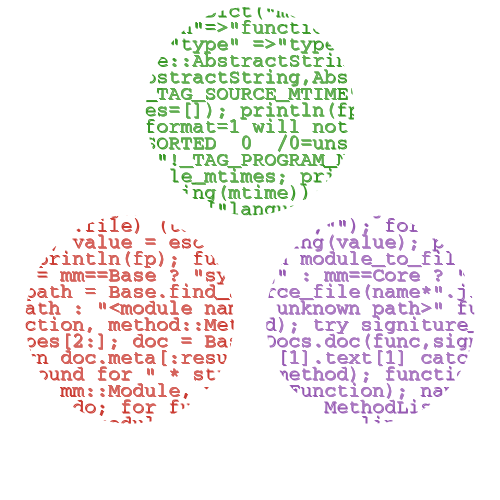

In [65]:
jeds_logo(500)